In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
import tqdm



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\loris.deluca\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("data/Reviews.csv")

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

Important point to check is how the data is distributed. 

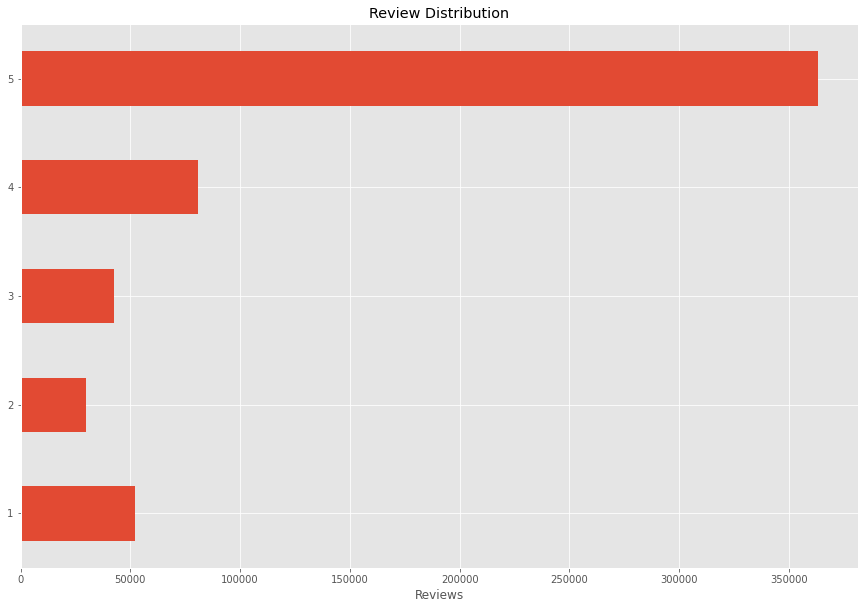

In [5]:
ax = df['Score'].value_counts()\
    .sort_index().plot(kind='barh',
    title='Review Distribution',
    figsize=(15,10))
ax.set_xlabel('Reviews')
plt.show()

Looks like the reviews are more prone towards positive ones. 

# VADER

### BOW Approach

In [6]:
sid = SIA()

In [7]:
df_vader = df.head(10000).copy()

In [8]:
def sentiment_vader(df_vader):
  result =  sid.polarity_scores(df_vader['Text'])
  df_vader['neu'] = result['neu']
  df_vader['pos'] = result['pos']
  df_vader['neg'] = result['neg']
  df_vader['compound'] = result['compound']
  return df_vader
  

In [9]:
df_vader = df_vader.apply(sentiment_vader, axis=1)

In [10]:
df_vader.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neu,pos,neg,compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.695,0.305,0.000,0.9441
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.862,0.000,0.138,-0.5664
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.754,0.155,0.091,0.8265
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.000,0.000,0.000,0.0000
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.552,0.448,0.000,0.9468


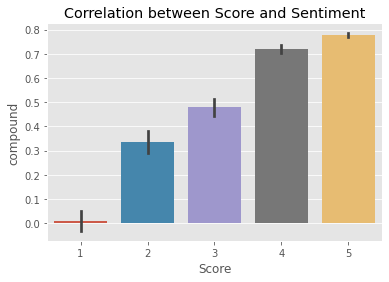

In [11]:
ax = sns.barplot(data=df_vader, x='Score', y='compound')
ax.set_title('Correlation between Score and Sentiment')
plt.show()

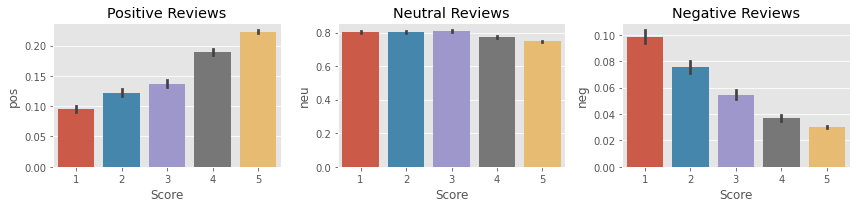

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=df_vader, x='Score', y='pos', ax=axs[0])
sns.barplot(data=df_vader, x='Score', y='neu', ax=axs[1])
sns.barplot(data=df_vader, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive Reviews')
axs[1].set_title('Neutral Reviews')
axs[2].set_title('Negative Reviews')
plt.tight_layout()
plt.show()


As the score goes higher, the sentiment goes higher, same for negative ones. 

# Hugging Face RoBERTA

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

c:\Users\loris.deluca\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [29]:
def roberta_sentiment(df_vader):
    encoded_text = tokenizer(df_vader['Text'], truncation=True, max_length=42, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    df_vader['rob_neg'] = scores[0]
    df_vader['rob_neu'] = scores[1]
    df_vader['rob_pos'] = scores[2]
    
    return df_vader


In [30]:
df_vader = df_vader.apply(roberta_sentiment, axis=1)

In [31]:
df_vader.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neu,pos,neg,compound,rob_neg,rob_neu,rob_pos
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.695,0.305,0.000,0.9441,0.006238,0.047374,0.946388
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.862,0.000,0.138,-0.5664,0.505681,0.453111,0.041208
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0.754,0.155,0.091,0.8265,0.047704,0.811250,0.141046
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.000,0.000,0.000,0.0000,0.004813,0.174611,0.820576
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.552,0.448,0.000,0.9468,0.001782,0.011369,0.986850


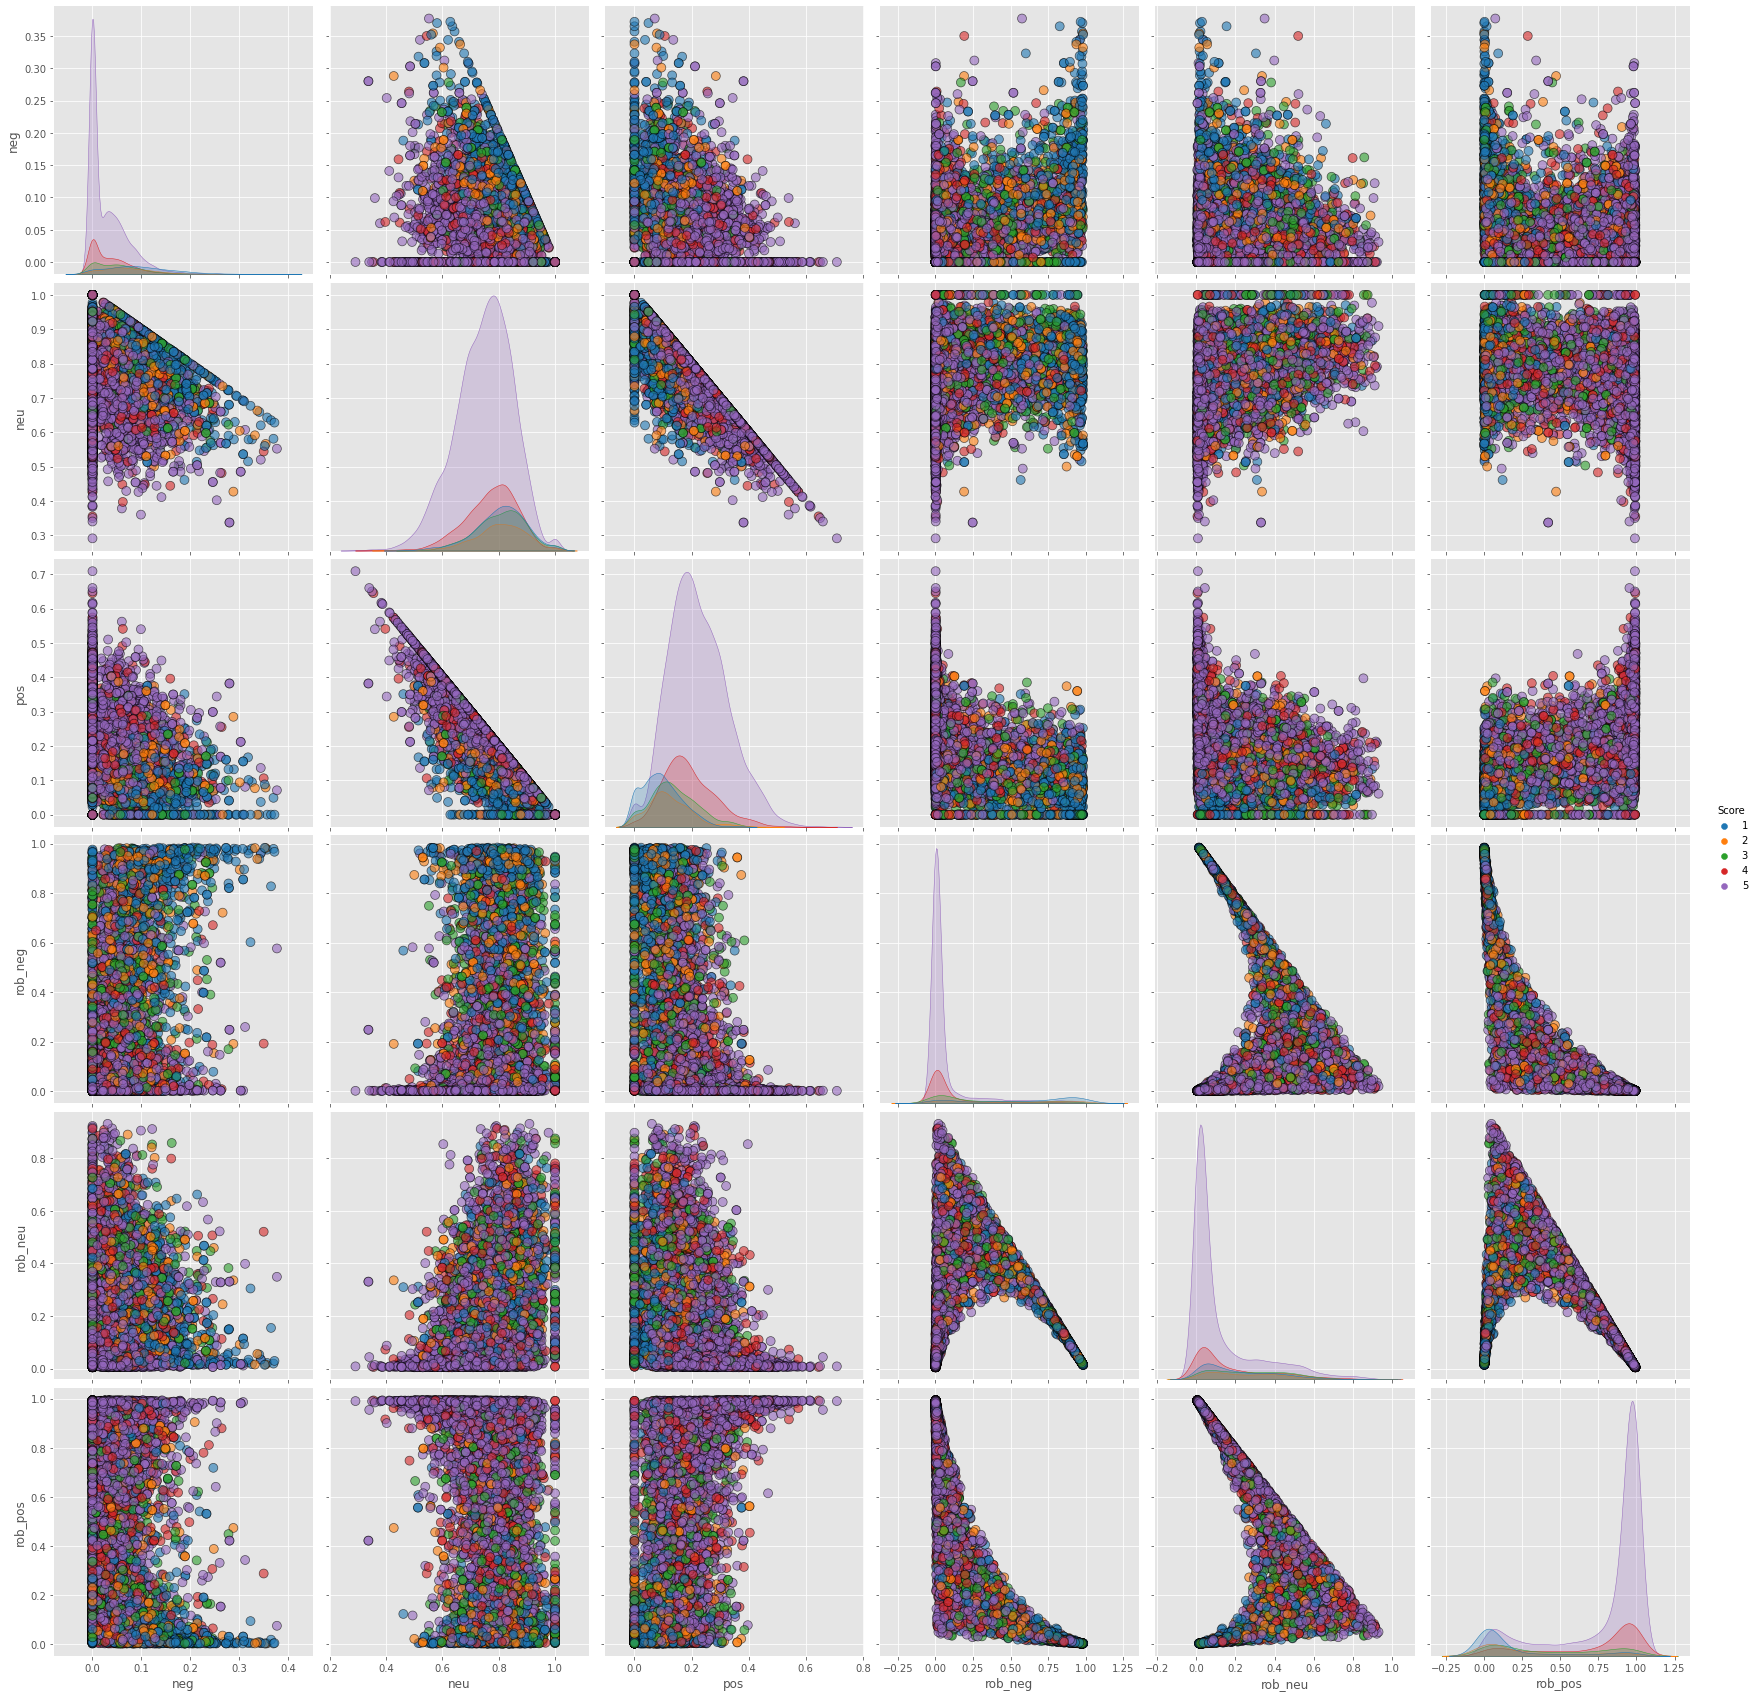

In [40]:
sns.pairplot(data=df_vader,
             vars=['neg', 'neu', 'pos',
                  'rob_neg', 'rob_neu', 'rob_pos'],
            hue='Score',
            diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4,
             palette='tab10')
plt.show()

## Misjudged Sentiment

### RoBERTa

In [41]:
df_vader.query('Score == 1').sort_values('rob_pos', ascending=False)['Text'].values[0]

'I was really excited and surprised when I found this mix in my local Wal Mart. Given it was a good price, I figured Id give it a shot.... before I whipped up a batch I figured Id do a little investigating to see if there was any input/ suggestions on the mix. WOW. Is everyone using the same mix or what? Reviews from "its great" to "its horrible"..like a total 50/50 split. SOOOooo, before  I wasted a bunch of money on products to whip up a batch and see for myself, I figured Id simply open the packae up and take a taste to the mix, all on its own.... ummmmm, yeah. It TOTALLY has a pretty strong bitter after taste. :/ And , like another reviewer, I had figured this mix would be adequately sweet enough for me and not need any extra sweetener (I dont like things very sweet, at all) but its DEF not. As I re read the ingredients I realized there isnt ANY sugar/sweetener in this mix so, youd def NEED to add sweetening. But, overall, I dont even plan on taking this mix that far. Im pretty cer

### Vader

In [42]:
df_vader.query('Score == 1').sort_values('pos', ascending=False)['Text'].values[0]

'This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!'